# Atividade avaliativa final - Tópicos especiais em business inteligence e analytics 3

# Alunos

* Lucas Oliveira Dantas
* Newton Pereira de Paiva
* Raphael Gonçalves Silva 
* Raphael Oliveira dos Reis

## Tópicos

- Introdução
- Estudo de caso
- Importando bibliotecas
- Importando o conjunto de dados
- Preparação do texto
- Contando as palavras
- Conclusão (falta fazer)

## Introdução

Neste notebook, apresentamos o uso de Machine Learning com Regressão Logística e `Processamento de Linguagem Natural (PLN)`, o nosso objetivo é a previsão das tags com base em perguntas mais frequentes das diversas áreas de *Tecnologia da Informação*, utilizamos um conjunto de dados (data sets) coletados do site **Hugging Face** (https://huggingface.co/datasets/fka/awesome-chatgpt-prompts).

Gráficos trazendo as top 10 pavras mais frequentes no modelo e outro gráfico com as tops 10 tags mais utilizados no modelo treinado.

* Repositório do Projeto no Github: https://github.com/LuksJobs/previsao-pln

## Estudo de caso

O **Problema de Negócio** que queremos resolver é `realizar predições das respectivas tags a partir das perguntas, através do aprendizado de máquina com algoritmo supervisionado`.

## Importando as bibliotecas

Para nosso estudo de caso, vamos fazer uso das seguintes bibliotecas:
- **Numpy**: um pacote para computação científica.
- **Pandas**: uma biblioteca de alta-performance, fácil para manipulação de dataframes e análises de dados.
- **seaborn**: para visualizações.
- **scikit-learn**: um pacote para ferramentas para aprendizado de máquinas.
- **NLTK**: uma plataforma para trabalhar com linguagem natural.

# Instalando as dependências (Pacotes) no Linux

* ```sudo apt install python3-numpy``` - Instalação da biblioteca do **Numpy** no Python3
* ```sudo apt install python3-pandas``` - Instalação da biblioteca do **Pandas** no Python3
* ```sudo apt install python3-seaborn``` - - Instalação da biblioteca do **Seaborn** no Python3
* ```sudo apt install python3-nltk``` - Instalação da biblioteca do **NLTK** no Python3
* ```sudo apt install python3-scikit-learn``` - Instalação da biblioteca do **SCIKIT** no Python3
* ```sudo apt install python3-matplotlib``` - - Instalação da biblioteca do **MATPLOTLIB** no Python3

In [42]:
# importando as bibliotecas
import nltk
from nltk.corpus import stopwords
from googletrans import Translator 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval
import re
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
#from metrics import roc_auc #deu erro na importação da biblioteca "metrics"

nltk.download('stopwords') # caso a lista esteja desatualizada
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raphaelreis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Neste projeto, contaremos com 2 conjuntos de dados: **treino** (train) e **validação** (validation), no qual é composto por `títulos` e suas `tags` correspondentes (somente essas duas colunas).

## Importando o conjunto de dados

Vamos iniciar criando um função para importação dos dados. Nessa importação as *tags* são importadas entre aspas simples, então utilizaremos a função `literal_eval` no qual converte a string em um objeto, para suprimirmos as aspas.

In [68]:
# Função para traduzir um texto de inglês para português
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text, src='en', dest='pt')
    return translation.text

# Função para traduzir as colunas relevantes do DataFrame
def translate_data(data):
    translated_data = data.copy()  # Crie uma cópia dos dados para evitar alterações nos originais
    translated_data['title'] = translated_data['title'].apply(translate_text)
    return translated_data

# criando a função
def read_data(filename):
    # importando o arquivo
    data = pd.read_csv(filename, sep='\t')
    
    # Tratar valores nan na coluna 'tags'
    # data['tags'].fillna('[]', inplace=True)
    data['tags'] = data['tags'].apply(literal_eval)
    
    # retornando o arquivo
    return data

Agora vamos importar os dois arquivos.

In [73]:
# importando os dados de treino
train = (read_data('data/train_pt.tsv'))

# importando os dados de validação
validation = (read_data('data/validation_pt.tsv'))

Vamos dar uma olhada nas primeiras linhas de cada conjunto com o método `head()`.

In [74]:
# visualizando as primeiras 8 linhas do conjunto de arquivos treinandos
train.head(8)

,title,tags
0,Como desenhar um dotplot empilhado em R? ['r'],[]
1,mysql seleciona todos os registros onde um cam...,[]
2,Como encerrar o aplicativo do Windows Phone 8....,[]
3,obter a hora atual em um pais especifico via j...,[]
4,Configurando o Tomcat para usar SSL ['java'],[]
5,Plugin de conjunto aninhado incrivel - como ad...,[]
6,Como criar mapa a partir de resposta JSON em R...,[]
7,teste rspec se o metodo for chamado ['ruby'],[]


In [28]:
# visualizando as primeiras 8 linhas do conjunto de arquivos validados
validation.head(8)

,title,tags
0,Why odbc_exec always fail?,"[php, sql]"
1,Access a base classes variable from within a c...,[javascript]
2,"Content-Type ""application/json"" not required i...","[ruby-on-rails, ruby]"
3,Sessions in Sinatra: Used to Pass Variable,"[ruby, session]"
4,"Getting error - type ""json"" does not exist - i...","[ruby-on-rails, ruby, json]"
5,library not found for.....?,"[c++, iphone, ios, xcode]"
6,.csproj File - Programmatic adding/deleting files,[c#]
7,TypeError: makedirs() got an unexpected keywor...,"[python, django]"


Podemos notar que temos aspas, underlines, dois pontos, traços na coluna **title** e a coluna **tags** não tem uma quantidade fixa de palavras, além de cada termo está em formato de lista.

Vamos agora dar uma olhada na dimensão desses dados.

In [ ]:
# visualizando as dimensões em quantidade de linhas e colunas dos dados de treino;
print(f"Os dados de TREINO possui:")
print(f"{train.shape[0]} linhas")
print(f"{train.shape[1]} colunas\n")

# visualizando as dimensões em quantidade de linhas e colunas dos dados de treino;
print(f"Os dados de VALIDAÇÃO possui:")
print(f"{validation.shape[0]} linhas")
print(f"{validation.shape[1]} colunas")

Os dados de TREINO possui:
100000 linhas
2 colunas

Os dados de VALIDAÇÃO possui:
30001 linhas
2 colunas


Observamos que o conjunto de validação corresponde à 30% do conjunto de treino, um número bom para utilizarmos como validação do nosso modelo.

Vamos então, separar nossa variável `preditora` (coluna **title**) da nossa variável `alvo` (coluna **tags**), em ambos os conjuntos, utilizaremos o método `values`.

In [ ]:
# separando os dados de treino
X_train, y_train = train['title'].values, train['tags'].values

# separando os dados de validação
X_val, y_val = validation['title'].values, validation['tags'].values

Os arquivos viraram uma lista, no qual cada linha se tornou um elemento dessa lista, vamos dar uma olhada para entendermos melhor no *X_train*, as outras seguem da mesma forma.

In [ ]:
# visualizando X_train
X_train

array(['How to draw a stacked dotplot in R?',
       'mysql select all records where a datetime field is less than a specified value',
       'How to terminate windows phone 8.1 app', ...,
       'Python Pandas Series of Datetimes to Seconds Since the Epoch',
       'jqGrid issue grouping - Duplicate rows get appended every time sort is changed',
       'Create a List of primitive int?'], dtype=object)

Em geral, quando trabalhamos com Processamento de Linguagem Natural, os **dados são desestruturados**, como podemos notar também nesse documento. **Devemos analisar com cautela** e escolher a melhor forma que não irá descaracterizar o sentido ou a palavra do que estamos tratando.

Vamos criar uma função para tratar nossos dados, removendo **símbolos** e **caracteres especiais** e também as **stopwords**, que são palavras que aparecem muitas vezes mas que não agregam valor ao nosso objetivo e se mantivermos podem causar ruidos e não termos uma boa precisão nas previsões.

## Preparação do texto

Nesta etapa vamos começar a "limpar" nosso texto, removendo tudo que não tem valor para nosso objetivo.

Vamos iniciar criando uma função para isso, fazendo uso do pacote `re`, *Regular Expression Operations* e com ela podemos utilizar dos recursos do REGEX.

Faremos uso do método *compile* (`re.compile`), dentro de um objeto, para compilar a *expressão regular* que queremos, com isso quando a função encontrar essa expressão no texto, ele a removerá. Podemos utilizar para remover caracteres especiais, números, entre outros padrões existentes. Depois usaremos esse objeto como uma função com o método `sub`, passando como parâmetros o que irá substituir e o conjunto de dados.

In [ ]:
# criando os objetos com as expressões regulares
remove_espec_carac = re.compile('[/(){}\[\]\|@,;]')
remove_symb = re.compile('[^0-9a-z #+_]')

# criando um objeto para remoção de stopwords no idioma ingles
stopwords = stopwords.words('portuguese')

# criando a função
def text_prepare(text):
    
    # normalizando nosso texto em letras minúsculas, assim facilita nossa preparação
    text = text.lower()
    
    # substituindo caracteres especiais por espaços em branco
    text = remove_espec_carac.sub(' ', text)
    
    # retornando apenas letras e números
    text = remove_symb.sub('', text)
    
    # removendo as stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    # retornando o texto modificado
    return text

Para verificarmos se nossa função de preparação está funcionando, vamos criar um pequeno texto com as informações que queremos remover e analisar.

In [ ]:
# Criando a função
def test_text_prepare():
    
    # definindo os exemplos
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    
    # inserindo a resposta correta
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    
    # Aplicando um loop e comparando a limpeza
    for ex, ans in zip(examples, answers):
        
    # condições para retornar se o resultado foi aprovado ou reprovado
        if text_prepare(ex) != ans:
            return "Resposta incorreta para: '%s'" % ex
    return 'Testes básicos aprovados.'

In [ ]:
# rodando a função de teste
print(test_text_prepare())

Testes básicos aprovados.


Nossa função passou no teste! Agora podemos pré-processar os *titles* usando a função **text_prepare** para os conjuntos de dados de treino e validação.

In [ ]:
# aplicando a função nos dados de treino
X_train = [text_prepare(x) for x in X_train]

# aplicando a função nos dados de validação
X_val = [text_prepare(x) for x in X_val]

Vamos dar uma olhada nas primeiras linhas, mas que na verdade são elementos porque estão contidos em uma lista e não mais como um dataframe.

In [27]:
# visualizando os 50 primeiros elementos
X_train[:50]

NameError: name 'X_train' is not defined

## Contando as palavras

Seguindo aqui com nosso texto "limpo", podemos calcular as quantidades de ocorrência de cada palavra nos conjuntos de treino. Vamos utilizar a função `Counter` do pacote `Collections` para fazer contagem e a função `chain` do pacote `itertools` que nos fornece um *loop* que irá iterar as palavras com suas respectivas frequencias. 

In [26]:
# realizando a contagem e inserindo em um dicionário
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

# ordenando do maior para o menor
words_freq = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

NameError: name 'X_train' is not defined

Vamos dar uma olhada no nas perguntas mais frequentes em uma escala de **TOP 50**, ou seja, as 50 palavras que mais apareceram.

In [ ]:
words_freq[:50]

[('using', 8278),
 ('php', 5614),
 ('java', 5501),
 ('file', 5055),
 ('javascript', 4746),
 ('error', 4388),
 ('get', 4301),
 ('c#', 4188),
 ('python', 4073),
 ('string', 3652),
 ('array', 3533),
 ('data', 3298),
 ('jquery', 3293),
 ('value', 3175),
 ('function', 2896),
 ('object', 2646),
 ('class', 2558),
 ('use', 2422),
 ('c++', 2312),
 ('list', 2137),
 ('method', 2123),
 ('multiple', 2096),
 ('text', 1929),
 ('image', 1849),
 ('page', 1847),
 ('rails', 1778),
 ('form', 1776),
 ('create', 1757),
 ('html', 1715),
 ('type', 1699),
 ('code', 1664),
 ('set', 1640),
 ('working', 1636),
 ('database', 1631),
 ('add', 1611),
 ('convert', 1586),
 ('mysql', 1572),
 ('json', 1557),
 ('c', 1550),
 ('server', 1543),
 ('variable', 1542),
 ('android', 1530),
 ('values', 1528),
 ('aspnet', 1506),
 ('way', 1454),
 ('application', 1451),
 ('change', 1441),
 ('button', 1385),
 ('find', 1383),
 ('django', 1373)]

Vamos visualizar em forma de gráfico, pois ficará mais visível e intuitivo, utilizando um `barplot` para visualizar.

Mas teremos que mudar o formato antes, pois como o resultado é uma tupla, vamos converter em um dicionário, separar e deixar as palavras em uma lista, assim como as ocorrências, separar e colocar também em outra lista.

In [19]:
# colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = words_list, y = occur_list)

# inserindo o título
ax.set_title('TOP 10 das palavras que mais frequentes no modelo treinado')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

NameError: name 'words_freq' is not defined

A palavra **using** é a que mais aparece, acredito que seja em função da maioria das perguntas serem sobre "como funciona" algo, em seguida entram algumas linguagens de programação, assim como buscas por erros.

Da mesma forma vamos fazer todo esse processo de contagem para as tags.

In [ ]:
# realizando a contagem e inserindo em um dicionário
tags_counts = Counter(chain.from_iterable([i for i in y_train]))

# ordenando do maior para o menor
tags_freq = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)

Vamos também dar uma olhada no **TOP 10**, as 10 tags que mais apareceram.

In [ ]:
tags_freq[:10]

[('javascript', 19078),
 ('c#', 19077),
 ('java', 18661),
 ('php', 13907),
 ('python', 8940),
 ('jquery', 7510),
 ('c++', 6469),
 ('html', 4668),
 ('objective-c', 4338),
 ('asp.net', 3939)]

Visualizando graficamente as **TOP 10** tags mais frequentes no modelo treinado.

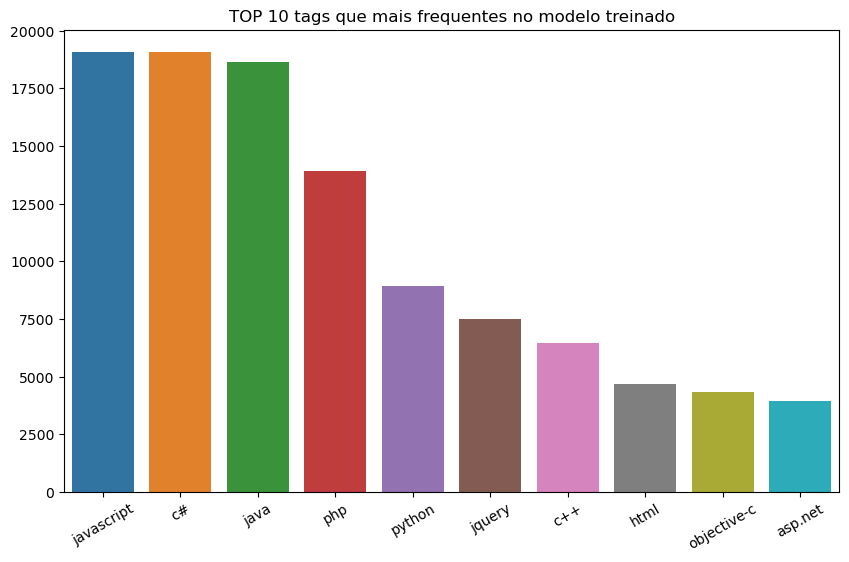

In [53]:
# colocando as palavras em um objeto do tipo lista
tags_list = list(dict(tags_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(tags_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = tags_list, y = occur_list)

# inserindo o título
ax.set_title('TOP 10 tags que mais frequentes no modelo treinado')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

As tags que mais aparecem são linguagens de Programação, no qual são relacionadas com as perguntas, sobre o *uso* ou *erros* contidos nas perguntas, por exemplo.

## Conclusão